# DEMO 

Program to read in the zarr collection and identify undefined points in the files used.  The tool is an example of how to find nan values and their associated time points.

The plots show if a variable has at least 1 point in the timeseries as a Nanl





#### required packages

In [4]:
import intake
import xarray as xr
from matplotlib import pyplot as plt

import glob
import pathlib
import traceback
from datetime import datetime

from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)


#### start a local Dask client

In [1]:
from dask.distributed import Client
import dask

# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

#cluster = LocalCluster(
#    n_workers=28,          # Number of workers
#    threads_per_worker=1 #Threads per worker
#    #memory_limit='8GB' # Memory limit per each worker commented out
#)
#client = Client(cluster)

client = Client()
client

2024-06-18 20:51:10,371 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-18 20:51:10,374 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-18 20:51:10,380 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0086.gadi.nci.org.au/39087/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0086.gadi.nci.org.au/39087/proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43593,Workers: 28
Dashboard: /node/gadi-cpu-bdw-0086.gadi.nci.org.au/39087/proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45201,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0086.gadi.nci.org.au/39087/proxy/33025/status,Memory: 0 B
Nanny: tcp://127.0.0.1:38767,


# Example code to read from command line if not interactive (just make the cell code)
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

from sys import argv

if is_interactive():
    params = [0, 0.001, 0.0042, 400, 8,16,16 ]
    params = [1, 0.000, 0.007, 400, 4,32,64 ]
    params = [1, 0.005, 0.001, 400, 4,32,64 ]
    params = [1, 0.00, 0.004, 161, 64,64,64 ]
else:
    print(argv)
    ss=argv[1:]
    print(ss)
    params = [float(i) for i in ss]
 
if params[0] == 0:
    loss='mean_squared_error'
else:
    loss='mean_absolute_error'#### ignore warnings

# 

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Obtain the desired catalogues of the simulations to processe

In [5]:
catalogue_path='/g/data/ia39/catalogues'
mRuns = sorted(glob.glob(catalogue_path+'/*ssp370*.json'))
print(len(mRuns))

13


In [6]:
# test loading all the catalogues of the data
ifile=-1
for file in mRuns: 
    ifile=ifile+1
    print(ifile, file)
    cat1=intake.open_esm_datastore(file)
#    tmp = cat1.search(variable={'pr'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})
#    print(ifile,len(tmp.time))



0 /g/data/ia39/catalogues/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day.json
1 /g/data/ia39/catalogues/AGCD-05i_BOM_ACCESS-ESM1-5_ssp370_r6i1p1f1_BARPA-R_v1-r1_day.json
2 /g/data/ia39/catalogues/AGCD-05i_BOM_CESM2_ssp370_r11i1p1f1_BARPA-R_v1-r1_day.json
3 /g/data/ia39/catalogues/AGCD-05i_BOM_CMCC-ESM2_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
4 /g/data/ia39/catalogues/AGCD-05i_BOM_EC-Earth3_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
5 /g/data/ia39/catalogues/AGCD-05i_BOM_MPI-ESM1-2-HR_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
6 /g/data/ia39/catalogues/AGCD-05i_BOM_NorESM2-MM_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
7 /g/data/ia39/catalogues/AGCD-05i_CSIRO_ACCESS-CM2_ssp370_r4i1p1f1_CCAM-v2203-SN_v1-r1_day.json
8 /g/data/ia39/catalogues/AGCD-05i_CSIRO_ACCESS-ESM1-5_ssp370_r6i1p1f1_CCAM-v2203-SN_v1-r1_day.json
9 /g/data/ia39/catalogues/AGCD-05i_CSIRO_CESM2_ssp370_r11i1p1f1_CCAM-v2203-SN_v1-r1_day.json
10 /g/data/ia39/catalogues/AGCD-05i_CSIRO_CMCC-ESM2_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1

# Process one ensemble 

In [14]:
# From one catalogue list save variables
mindex=12  # run to process
mindex=1
cat=intake.open_esm_datastore(mRuns[mindex])
mtmp=mRuns[mindex].split('/')
model_name=mtmp[5].split('.')
print(model_name)
print(cat.unique()['variable']) #unique()['variable']
tmp=model_name[0].split('_'); ACS_model=tmp[1]

['AGCD-05i_BOM_ACCESS-ESM1-5_ssp370_r6i1p1f1_BARPA-R_v1-r1_day', 'json']
['hursmax', 'hursmin', 'pr', 'rsds', 'sfcWindmax', 'tasmax', 'tasmin']


# Extra plotting of written file

If any of these variables have nan than the FFDI calculation will fail

In [15]:
target_store = "/scratch/xv83/rxm599/"+model_name[0]+".zarr"
ds0=xr.open_zarr(target_store)
ds0

<xarray.Dataset>
Dimensions:     (time: 31411, lat: 691, lon: 886, bnds: 2)
Coordinates:
  * lat         (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>
  * lon         (lon) float64 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(43, 2), meta=np.ndarray>
  * time        (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:0...
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(31411, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    hursmin     (time, lat, lon) float64 dask.array<chunksize=(31411, 33, 43), meta=np.ndarray>
    pr          (time, lat, lon) float64 dask.array<chunksize=(31411, 33, 43), meta=np.ndarray>
    sfcWindmax  (time, lat, lon) float64 dask.array<chunksize=(31411, 33, 43), meta=np.ndarray>
    tasmax      (time, lat, lon) float64 dask.array<chunksize=(31411, 33, 43), meta=np.ndarray>
Attributes: (12/54)
    Conventions:                         CF-1.10, ACDD-1.3
    NCO:                                 netCDF Operators version 5.0.5 (Home...
    acknowledgement:                     The production of BARPA was supporte...
    activity_id:                         DD
    contact:                             Bureau of Meteorology (data_governan...
    creator_institution:                 Bureau of Meteorology
    ...                                  ...
    standard_name_vocabulary:            CF Standard Name Table v79
    summary:                             The Bureau of Meteorology Atmospheri...
    time_coverage_resolution:            PT1440M0S
    title:                               Pre-processed model output in prepar...
    variable_id:                         pr
    version_realisation:                 v1-r1

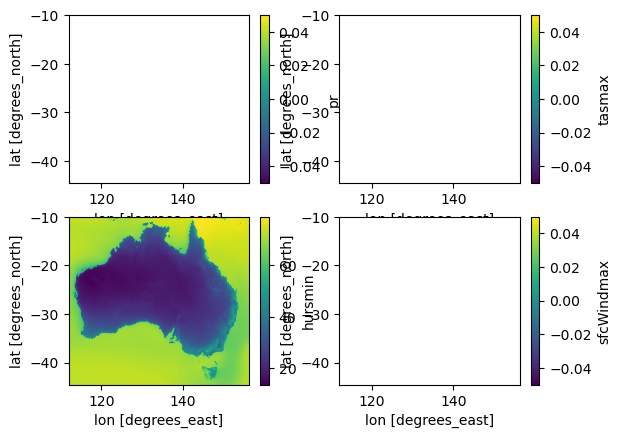

In [16]:
t1='2015-01-01'; t2='2099-12-31'
pra=ds0.pr.sel(time=slice(t1, t2))
tasmaxa=ds0.tasmax.sel(time=slice(t1,t2))
hursmina=ds0.hursmin.sel(time=slice(t1,t2))
sfcWindmaxa=ds0.sfcWindmax.sel(time=slice(t1,t2))

plt.subplot(2,2,1); pra.mean('time',skipna=False).plot()
plt.subplot(2,2,2); tasmaxa.mean('time',skipna=False).plot()
plt.subplot(2,2,3); hursmina.mean('time',skipna=False).plot()
plt.subplot(2,2,4); sfcWindmaxa.mean('time',skipna=False).plot()

In [17]:
nan_count = pra.isel(time=slice(0,None),lon=140,lat=-30).isnull().sum().compute().item()
print(nan_count)

2


In [18]:
nan1=pra.isnull().sum().compute().item()
print(nan1)
nan2=sfcWindmaxa.isnull().sum().compute().item()
print(nan2)
nan3=tasmaxa.isnull().sum().compute().item()
print(nan3)
nan4=hursmina.isnull().sum().compute().item()
print(nan4)
print(nan1,nan2,nan3,nan4)

1224452
1224452
1224452
0
1224452 1224452 1224452 0


In [22]:
print(691*886*2,target_store)

1224452 /scratch/xv83/rxm599/AGCD-05i_BOM_ACCESS-ESM1-5_ssp370_r6i1p1f1_BARPA-R_v1-r1_day.zarr


In [24]:
# Find the indices of NaN values
def nan_var(var):
    nan_mask = var.isel(time=slice(0,None),lon=140,lat=-30).isnull().compute()
    nan_indices = nan_mask.where(nan_mask, drop=True).time
    print(f"Indices of NaN values in :\n{nan_indices.values}")

nan_var(tasmaxa)
nan_var(sfcWindmaxa)
nan_var(pra)

Indices of NaN values in :
['2029-04-21T12:00:00.000000000' '2029-04-22T12:00:00.000000000']
Indices of NaN values in :
['2029-04-21T12:00:00.000000000' '2029-04-22T12:00:00.000000000']
Indices of NaN values in :
['2029-04-21T12:00:00.000000000' '2029-04-22T12:00:00.000000000']


In [21]:
#client.shutdown()